<a href="https://colab.research.google.com/github/MeedumiRashmika/Researchbasic/blob/main/new_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow pandas numpy scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
from google.colab import files

print("Upload Model 1 dataset (shelf life)...")
uploaded1 = files.upload()

print("Upload Model 2 dataset (packaging)...")
uploaded2 = files.upload()

# Adjust filenames if different
df1 = pd.read_excel("model1_shelf_life_1349_rows.xlsx")
df2 = pd.read_excel("model2_mango_packaging_1249rows.xlsx")

print("Model 1 shape:", df1.shape)
print(df1.head())

print("Model 2 shape:", df2.shape)
print(df2.head())


Upload Model 1 dataset (shelf life)...


Saving model1_shelf_life_1349_rows.xlsx to model1_shelf_life_1349_rows.xlsx
Upload Model 2 dataset (packaging)...


Saving model2_mango_packaging_1249rows.xlsx to model2_mango_packaging_1249rows.xlsx
Model 1 shape: (1349, 6)
  ripeness_level  avg_weight_g origin_location_district  avg_temperature_C  \
0         Unripe           305             Anuradhapura               31.0   
1         Unripe           298                   Jaffna               32.0   
2         Unripe           310               Kurunegala               30.0   
3         Unripe           290                  Gampaha               29.0   
4         Unripe           315                    Kandy               24.0   

   avg_humidity_pct  predicted_shelf_life_days  
0                68                       15.0  
1                70                       14.0  
2                72                       16.0  
3                75                       17.0  
4                80                       18.0  
Model 2 shape: (1249, 21)
  ripeness_level  avg_weight_g  number_of_mangoes origin_country  \
0           Ripe         311.0    

In [3]:
model1_feature_cols = ["ripeness_level", "avg_weight_g", "avg_temperature_C", "avg_humidity_pct"]
model1_label_col = "predicted_shelf_life_days"

X1 = df1[model1_feature_cols].copy()
y1 = df1[model1_label_col].astype("float32")

m1_cat_cols = ["ripeness_level"]
m1_num_cols = ["avg_weight_g", "avg_temperature_C", "avg_humidity_pct"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)


In [4]:
inputs_m1 = {}

for col in m1_cat_cols:
    inputs_m1[col] = keras.Input(shape=(1,), name=col, dtype=tf.string)
for col in m1_num_cols:
    inputs_m1[col] = keras.Input(shape=(1,), name=col, dtype=tf.float32)

# Categorical preprocessing
encoded_cat_features = []
for col in m1_cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{col}_lookup")
    lookup.adapt(X1_train[col].values)
    encoder = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(),
                                      output_mode="one_hot",
                                      name=f"{col}_onehot")
    x = lookup(inputs_m1[col])
    x = encoder(x)
    encoded_cat_features.append(x)

# Numeric preprocessing
normalized_num_features = []
for col in m1_num_cols:
    norm = layers.Normalization(name=f"{col}_norm")
    norm.adapt(X1_train[col].values.reshape(-1, 1))
    x = norm(inputs_m1[col])
    normalized_num_features.append(x)

# Concatenate all
all_features_m1 = layers.concatenate(encoded_cat_features + normalized_num_features)


In [21]:
x = layers.Dense(64, activation="relu")(all_features_m1)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output_m1 = layers.Dense(1, name="shelf_life_days")(x)

model1_tf = keras.Model(inputs=inputs_m1, outputs=output_m1)

model1_tf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model1_tf.summary()

train_dict_m1 = {col: X1_train[col].values for col in model1_feature_cols}

early_stop_m1 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history_m1 = model1_tf.fit(
    train_dict_m1,
    y1_train.values,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_m1],
    verbose=1
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ripeness_level      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_loo… │ (None, 1)         │          0 │ ripeness_level[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_temperature_C   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_humidity_pct    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_one… │ (None, 4)         │          0 │ ripeness_level_l… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g_norm   │ (None, 1)         │          3 │ avg_weight_g[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_temperature_C_… │ (None, 1)         │          3 │ avg_temperature_… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_humidity_pct_n… │ (None, 1)         │          3 │ avg_humidity_pct… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7)         │          0 │ ripeness_level_o… │
│ (Concatenate)       │                   │            │ avg_weight_g_nor… │
│                     │                   │            │ avg_temperature_… │
│                     │                   │            │ avg_humidity_pct… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │        512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      4,160 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 32)        │      2,080 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shelf_life_days     │ (None, 1)         │         33 │ dense_17[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,794 (26.55 KB)

 Trainable params: 6,785 (26.50 KB)

 Non-trainable params: 9 (48.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 121.2051 - mae: 9.9154 - val_loss: 103.3489 - val_mae: 8.7963
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 76.3488 - mae: 7.3208 - val_loss: 26.1008 - val_mae: 4.2108
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.4759 - mae: 3.5301 - val_loss: 8.5090 - val_mae: 2.3031
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4648 - mae: 2.2080 - val_loss: 5.4731 - val_mae: 1.8147
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6282 - mae: 1.7384 - val_loss: 3.7565 - val_mae: 1.5045
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1968 - mae: 1.4408 - val_loss: 2.6314 - val_mae: 1.2624
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2174 - mae: 1.2079 - val_loss: 1.8253 - val_mae: 1.0692
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5538 - mae: 1.0170 - val_loss: 1.3181 - val_mae: 0.9227
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - los

Model 1 Evaluation:
Test Loss (MSE): 0.6043
Test MAE: 0.6252
Model 1 R²: 0.9767313599586487


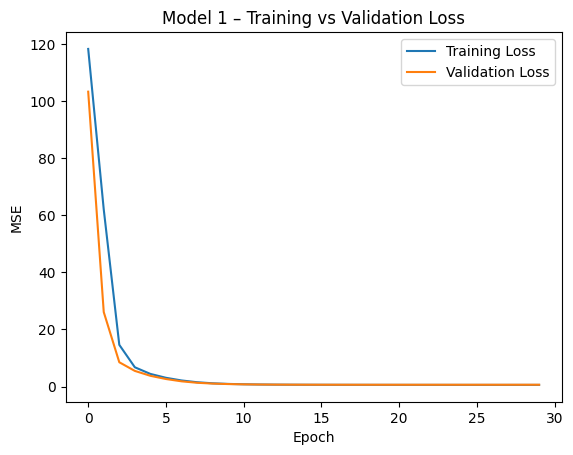

In [22]:
import tensorflow as tf

test_dict_m1 = {}
for col in model1_feature_cols:
    if col in m1_cat_cols:
        # Explicitly convert categorical string data to TensorFlow string tensors
        test_dict_m1[col] = tf.constant(X1_test[col].values.reshape(-1, 1), dtype=tf.string)
    else:
        # Explicitly convert numerical data to TensorFlow float32 tensors
        test_dict_m1[col] = tf.constant(X1_test[col].values.reshape(-1, 1), dtype=tf.float32)

# Also ensure y1_test is a tf.Tensor for consistency
y1_test_tensor = tf.constant(y1_test.values, dtype=tf.float32)

m1_eval = model1_tf.evaluate(test_dict_m1, y1_test_tensor, verbose=0)
print("Model 1 Evaluation:")
print(f"Test Loss (MSE): {m1_eval[0]:.4f}")
print(f"Test MAE: {m1_eval[1]:.4f}")

y1_pred = model1_tf.predict(test_dict_m1, verbose=0).flatten()
r2_m1 = r2_score(y1_test, y1_pred)
print("Model 1 R²:", r2_m1)

plt.plot(history_m1.history["loss"], label="Training Loss")
plt.plot(history_m1.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Model 1 – Training vs Validation Loss")
plt.legend()
plt.show()

MODEL 2 (Damage % with Eco + Legal Rules)


In [7]:
model2_feature_cols = [
    "ripeness_level",
    "avg_weight_g",
    "number_of_mangoes",
    "origin_country",
    "origin_port_airport",
    "destination_country",
    "destination_port_airport",
    "transport_mode",
    "transport_duration_days",
    "predicted_shelf_life_days",
    "packaging_material",
    "padding_type",
    "box_length_cm",
    "box_width_cm",
    "box_height_cm",
    "rows_per_layer",
    "items_per_row",
    "layers",
    "mangoes_per_box"
]

model2_label_col = "observed_damage_pct"

X2 = df2[model2_feature_cols].copy()
y2 = df2[model2_label_col].astype("float32")

m2_cat_cols = [
    "ripeness_level",
    "origin_country",
    "origin_port_airport",
    "destination_country",
    "destination_port_airport",
    "transport_mode",
    "packaging_material",
    "padding_type"
]

m2_num_cols = [c for c in model2_feature_cols if c not in m2_cat_cols]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)


In [23]:
inputs_m2 = {}

for col in m2_cat_cols:
    inputs_m2[col] = keras.Input(shape=(1,), name=col, dtype=tf.string)
for col in m2_num_cols:
    inputs_m2[col] = keras.Input(shape=(1,), name=col, dtype=tf.float32)

# Categorical
encoded_cat_features_2 = []
for col in m2_cat_cols:
    lookup = layers.StringLookup(output_mode="int", name=f"{col}_lookup")
    lookup.adapt(X2_train[col].values)
    encoder = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(),
                                      output_mode="one_hot",
                                      name=f"{col}_onehot")
    x = lookup(inputs_m2[col])
    x = encoder(x)
    encoded_cat_features_2.append(x)

# Numeric
normalized_num_features_2 = []
for col in m2_num_cols:
    norm = layers.Normalization(name=f"{col}_norm")
    norm.adapt(X2_train[col].values.reshape(-1, 1))
    x = norm(inputs_m2[col])
    normalized_num_features_2.append(x)

all_features_m2 = layers.concatenate(encoded_cat_features_2 + normalized_num_features_2)

# Deep model
x2 = layers.Dense(128, activation="relu")(all_features_m2)
x2 = layers.Dense(128, activation="relu")(x2)
x2 = layers.Dense(64, activation="relu")(x2)
output_m2 = layers.Dense(1, name="damage_pct")(x2)

model2_tf = keras.Model(inputs=inputs_m2, outputs=output_m2)

model2_tf.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model2_tf.summary()

train_dict_m2 = {col: X2_train[col].values for col in model2_feature_cols}

early_stop_m2 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history_m2 = model2_tf.fit(
    train_dict_m2,
    y2_train.values,
    validation_split=0.2,
    epochs=120,
    batch_size=32,
    callbacks=[early_stop_m2],
    verbose=1
)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ripeness_level      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_country      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_port_airport │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_country │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_port_a… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transport_mode      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ packaging_material  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_type        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ripeness_level_loo… │ (None, 1)         │          0 │ ripeness_level[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_country_loo… │ (None, 1)         │          0 │ origin_country[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ origin_port_airpor… │ (None, 1)         │          0 │ origin_port_airp… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_countr… │ (None, 1)         │          0 │ destination_coun… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_port_a… │ (None, 1)         │          0 │ destination_port… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transport_mode_loo… │ (None, 1)         │          0 │ transport_mode[0… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ packaging_material… │ (None, 1)         │          0 │ packaging_materi… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_type_lookup │ (None, 1)         │          0 │ padding_type[0][… │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg_weight_g        │ (None, 1)         │          0 │ -               

 Total params: 33,442 (130.68 KB)

 Trainable params: 33,409 (130.50 KB)

 Non-trainable params: 33 (176.00 B)

Epoch 1/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 75.5480 - mae: 7.3868 - val_loss: 19.9072 - val_mae: 3.5629
Epoch 2/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.8998 - mae: 3.2118 - val_loss: 6.7495 - val_mae: 1.9463
Epoch 3/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0491 - mae: 1.9856 - val_loss: 5.7379 - val_mae: 1.8169
Epoch 4/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8938 - mae: 1.7812 - val_loss: 5.2644 - val_mae: 1.7428
Epoch 5/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1261 - mae: 1.6257 - val_loss: 4.8541 - val_mae: 1.6866
Epoch 6/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5074 - mae: 1.4887 - val_loss: 4.4259 - val_mae: 1.6185
Epoch 7/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9992 - mae: 1.3721 - val_loss: 3.9881 - val_mae: 1.5396
Epoch 8/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5974 - mae: 1.2781 - val_loss: 3.5920 - val_mae: 1.4673
Epoch 9/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2

Model 2 Evaluation:
Test Loss (MSE): 2.1677
Test MAE: 1.1808
Model 2 R²: 0.8996545672416687


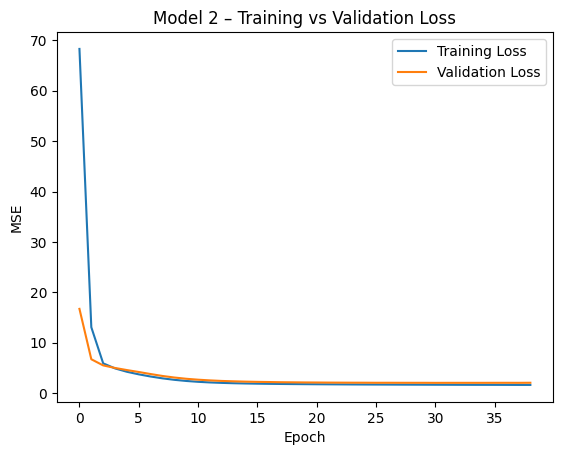

In [9]:
import tensorflow as tf

test_dict_m2 = {}
for col in model2_feature_cols:
    if col in m2_cat_cols:
        # Explicitly convert categorical string data to TensorFlow string tensors
        test_dict_m2[col] = tf.constant(X2_test[col].values.reshape(-1, 1), dtype=tf.string)
    else:
        # Explicitly convert numerical data to TensorFlow float32 tensors
        test_dict_m2[col] = tf.constant(X2_test[col].values.reshape(-1, 1), dtype=tf.float32)

# Also ensure y2_test is a tf.Tensor for consistency
y2_test_tensor = tf.constant(y2_test.values, dtype=tf.float32)

m2_eval = model2_tf.evaluate(test_dict_m2, y2_test_tensor, verbose=0)
print("Model 2 Evaluation:")
print(f"Test Loss (MSE): {m2_eval[0]:.4f}")
print(f"Test MAE: {m2_eval[1]:.4f}")

y2_pred = model2_tf.predict(test_dict_m2, verbose=0).flatten()
r2_m2 = r2_score(y2_test, y2_pred)
print("Model 2 R²:", r2_m2)

plt.plot(history_m2.history["loss"], label="Training Loss")
plt.plot(history_m2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Model 2 – Training vs Validation Loss")
plt.legend()
plt.show()

In [10]:
transport_table = {
    ("UAE", "Air"): 1,
    ("UAE", "Sea"): 16,
    ("Qatar", "Air"): 1,
    ("Qatar", "Sea"): 12,
    ("Saudi Arabia", "Air"): 1,
    ("Saudi Arabia", "Sea"): 9,
    ("Oman", "Air"): 1,
    ("Oman", "Sea"): 8,
    ("Kuwait", "Air"): 1,
    ("Kuwait", "Sea"): 14,
    ("Germany", "Air"): 2,
    ("Germany", "Sea"): 22,
    ("Netherlands", "Air"): 2,
    ("Netherlands", "Sea"): 24,
    ("UK", "Air"): 2,
    ("UK", "Sea"): 21,
    ("Japan", "Air"): 2,
    ("Japan", "Sea"): 18,
    ("United States", "Air"): 2,
    ("United States", "Sea"): 30,
    ("Australia", "Air"): 2,
    ("Australia", "Sea"): 16,
}

def get_transport_duration(destination_country, mode):
    return transport_table.get((destination_country, mode), 10)


In [11]:
legal_rules = {
    "Germany": {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": ["FoamBox"]
    },
    "Netherlands": {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": ["FoamBox"]
    },
    "UK": {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": ["FoamBox"]
    },
    "United States": {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": ["FoamBox"]  # many states ban EPS
    },
    "UAE": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["BioFiber", "FoamBox"]
    },
    "Qatar": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["BioFiber", "FoamBox"]
    },
    "Saudi Arabia": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["BioFiber", "FoamBox"]
    },
    "Oman": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["BioFiber", "FoamBox"]
    },
    "Kuwait": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["BioFiber", "FoamBox"]
    },
    "Japan": {
        "allowed": ["Fiberboard", "Cardboard"],
        "banned": ["FoamBox"]
    },
    "Australia": {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": ["FoamBox"]
    }
}

eco_score = {
    "BioFiber": 1,     # most eco
    "Fiberboard": 2,
    "Cardboard": 3,
    "FoamBox": 5       # worst, mostly banned
}


In [12]:
candidate_packaging_options = [
    # 20 mangoes
    {"packaging_material": "Fiberboard", "padding_type": "Foam",    "box_length_cm": 40, "box_width_cm": 30, "box_height_cm": 18, "rows_per_layer": 4, "items_per_row": 5, "layers": 1},
    # 16 mangoes
    {"packaging_material": "Fiberboard", "padding_type": "Paper",   "box_length_cm": 40, "box_width_cm": 30, "box_height_cm": 16, "rows_per_layer": 4, "items_per_row": 4, "layers": 1},
    # 12 mangoes
    {"packaging_material": "BioFiber",   "padding_type": "Foam",    "box_length_cm": 38, "box_width_cm": 28, "box_height_cm": 16, "rows_per_layer": 3, "items_per_row": 4, "layers": 1},
    # 15 mangoes
    {"packaging_material": "Cardboard",  "padding_type": "Paper",   "box_length_cm": 40, "box_width_cm": 30, "box_height_cm": 16, "rows_per_layer": 3, "items_per_row": 5, "layers": 1},
    # 40 mangoes (export bulk)
    {"packaging_material": "Fiberboard", "padding_type": "Foam",    "box_length_cm": 42, "box_width_cm": 32, "box_height_cm": 18, "rows_per_layer": 4, "items_per_row": 5, "layers": 2},
    # Extra eco option
    {"packaging_material": "BioFiber",   "padding_type": "Paper",   "box_length_cm": 38, "box_width_cm": 28, "box_height_cm": 18, "rows_per_layer": 3, "items_per_row": 4, "layers": 2},
]


In [13]:
def recommend_packaging(
    ripeness_level,
    avg_weight_g,
    number_of_mangoes,
    destination_country,
    transport_mode,
    origin_country="Sri Lanka",
    avg_temperature_C=28.0,
    avg_humidity_pct=75.0
):
    # 1) Origin port / airport
    origin_port_airport = "Colombo Port" if transport_mode == "Sea" else "CMB Airport"

    # 2) Predict shelf life using Model 1
    # Explicitly convert inputs to TensorFlow tensors with correct dtypes and shapes
    shelf_input = {
        "ripeness_level": tf.reshape(tf.constant([ripeness_level], dtype=tf.string), (-1, 1)),
        "avg_weight_g": tf.reshape(tf.constant([avg_weight_g], dtype=tf.float32), (-1, 1)),
        "avg_temperature_C": tf.reshape(tf.constant([avg_temperature_C], dtype=tf.float32), (-1, 1)),
        "avg_humidity_pct": tf.reshape(tf.constant([avg_humidity_pct], dtype=tf.float32), (-1, 1)),
    }

    predicted_shelf_life = float(model1_tf.predict(shelf_input, verbose=0)[0][0])

    # 3) Get transport duration
    transport_duration_days = get_transport_duration(destination_country, transport_mode)

    # 4) Build candidate rows for Model 2
    candidate_rows = []

    for opt in candidate_packaging_options:
        rows_per_layer = opt["rows_per_layer"]
        items_per_row = opt["items_per_row"]
        layers = opt["layers"]
        mangoes_per_box = rows_per_layer * items_per_row * layers

        candidate_rows.append({
            "ripeness_level": ripeness_level,
            "avg_weight_g": float(avg_weight_g),
            "number_of_mangoes": int(number_of_mangoes),
            "origin_country": origin_country,
            "origin_port_airport": origin_port_airport,
            "destination_country": destination_country,
            "destination_port_airport": "DEST_PORT_OR_AIRPORT",  # you can map real ports
            "transport_mode": transport_mode,
            "transport_duration_days": float(transport_duration_days),
            "predicted_shelf_life_days": float(predicted_shelf_life),
            "packaging_material": opt["packaging_material"],
            "padding_type": opt["padding_type"],
            "box_length_cm": float(opt["box_length_cm"]),
            "box_width_cm": float(opt["box_width_cm"]),
            "box_height_cm": float(opt["box_height_cm"]),
            "rows_per_layer": float(rows_per_layer),
            "items_per_row": float(items_per_row),
            "layers": float(layers),
            "mangoes_per_box": float(mangoes_per_box),
        })

    df_candidates = pd.DataFrame(candidate_rows)

    # 5) Predict damage using Model 2
    # Explicitly convert inputs to TensorFlow tensors with correct dtypes and shapes
    input_dict_m2 = {}
    for col in model2_feature_cols:
        if col in m2_cat_cols:
            input_dict_m2[col] = tf.reshape(tf.constant(df_candidates[col].values, dtype=tf.string), (-1, 1))
        else:
            input_dict_m2[col] = tf.reshape(tf.constant(df_candidates[col].values, dtype=tf.float32), (-1, 1))

    damage_preds = model2_tf.predict(input_dict_m2, verbose=0).flatten()
    df_candidates["predicted_damage_pct"] = damage_preds

    # 6) Apply eco + legal rules
    rules = legal_rules.get(destination_country, {
        "allowed": ["Fiberboard", "Cardboard", "BioFiber"],
        "banned": []
    })

    def is_allowed(row):
        mat = row["packaging_material"]
        if mat in rules["banned"]:
            return False
        if mat not in rules["allowed"]:
            return False
        return True

    df_candidates["is_allowed"] = df_candidates.apply(is_allowed, axis=1)

    allowed_df = df_candidates[df_candidates["is_allowed"] == True].copy()
    if allowed_df.empty:
        # Fallback: choose lowest damage ignoring legality
        df_sorted = df_candidates.sort_values("predicted_damage_pct")
        best = df_sorted.iloc[0]
        return best, None, df_candidates

    # Rank by eco_score then damage
    allowed_df["eco_rank"] = allowed_df["packaging_material"].map(eco_score)
    allowed_df = allowed_df.sort_values(["eco_rank", "predicted_damage_pct"])

    best_option = allowed_df.iloc[0]
    second_option = allowed_df.iloc[1] if len(allowed_df) > 1 else None

    return best_option, second_option, allowed_df

In [14]:
best, second, all_allowed = recommend_packaging(
    ripeness_level="Semi-ripe",
    avg_weight_g=300,
    number_of_mangoes=1200,
    destination_country="Germany",
    transport_mode="Sea"
)

print("✅ Best Recommended Option:")
print(best[[
    "packaging_material", "padding_type",
    "box_length_cm", "box_width_cm", "box_height_cm",
    "rows_per_layer", "items_per_row", "layers",
    "mangoes_per_box", "predicted_damage_pct"
]])

if second is not None:
    print("\n🟡 Second-Best Legal & Eco-Friendly Option:")
    print(second[[
        "packaging_material", "padding_type",
        "box_length_cm", "box_width_cm", "box_height_cm",
        "rows_per_layer", "items_per_row", "layers",
        "mangoes_per_box", "predicted_damage_pct"
    ]])

✅ Best Recommended Option:
packaging_material      BioFiber
padding_type               Paper
box_length_cm               38.0
box_width_cm                28.0
box_height_cm               18.0
rows_per_layer               3.0
items_per_row                4.0
layers                       2.0
mangoes_per_box             24.0
predicted_damage_pct    11.17081
Name: 5, dtype: object

🟡 Second-Best Legal & Eco-Friendly Option:
packaging_material       BioFiber
padding_type                 Foam
box_length_cm                38.0
box_width_cm                 28.0
box_height_cm                16.0
rows_per_layer                3.0
items_per_row                 4.0
layers                        1.0
mangoes_per_box              12.0
predicted_damage_pct    13.798483
Name: 2, dtype: object


In [15]:
# ===========================
# FINAL OUTPUT LOGIC (UPDATED)
# ===========================

def display_final_recommendation(best_option, second_option, destination_country):
    rules = legal_rules.get(destination_country, {"allowed": [], "banned": []})

    best_mat = best_option["packaging_material"]

    # Check if BEST option is legally allowed
    if best_mat in rules["banned"] or best_mat not in rules["allowed"]:
        print("❌ Best predicted packaging is NOT allowed in", destination_country)
        print("\n➡ Material:", best_mat)
        print("Reason: Violates eco/legal rules of", destination_country)

        if second_option is not None:
            print("\n✅ Using Second-Best Allowed Packaging Instead:")
            print("Recommended Material:", second_option["packaging_material"])
            print("Padding:", second_option["padding_type"])
            print("Box Size (LxWxH):",
                  second_option["box_length_cm"],
                  second_option["box_width_cm"],
                  second_option["box_height_cm"])
            print("Layers:", second_option["layers"])
            print("Mangoes per box:", second_option["mangoes_per_box"])
            print("Predicted Damage %:", round(second_option["predicted_damage_pct"], 2))
            print("Eco Rank:", eco_score[second_option["packaging_material"]])
        else:
            print("\n⚠ No legal secondary option available.")
        return

    # If BEST option is allowed, show final output:
    print("✅ BEST Packaging Option is Legal & Recommended for", destination_country)
    print("\nRecommended Material:", best_option["packaging_material"])
    print("Padding:", best_option["padding_type"])
    print("Box Size (LxWxH):",
          best_option["box_length_cm"],
          best_option["box_width_cm"],
          best_option["box_height_cm"])
    print("Layers:", best_option["layers"])
    print("Mangoes per box:", best_option["mangoes_per_box"])
    print("Predicted Damage %:", round(best_option["predicted_damage_pct"], 2))
    print("Eco Rank:", eco_score[best_option["packaging_material"]])

    if second_option is not None:
        print("\n📌 Alternate Safe Option Available:")
        print(second_option[["packaging_material", "padding_type",
                             "box_length_cm", "box_width_cm", "box_height_cm",
                             "layers", "mangoes_per_box", "predicted_damage_pct"]])


In [16]:
best, second, all_allowed = recommend_packaging(
    ripeness_level="Semi-ripe",
    avg_weight_g=300,
    number_of_mangoes=1200,
    destination_country="Germany",
    transport_mode="Sea"
)

display_final_recommendation(best, second, "Germany")


✅ BEST Packaging Option is Legal & Recommended for Germany

Recommended Material: BioFiber
Padding: Paper
Box Size (LxWxH): 38.0 28.0 18.0
Layers: 2.0
Mangoes per box: 24.0
Predicted Damage %: 11.17
Eco Rank: 1

📌 Alternate Safe Option Available:
packaging_material       BioFiber
padding_type                 Foam
box_length_cm                38.0
box_width_cm                 28.0
box_height_cm                16.0
layers                        1.0
mangoes_per_box              12.0
predicted_damage_pct    13.798483
Name: 2, dtype: object
